# 환경설정

## 경로설정

In [1]:
# local과 google 중 하나 입력
drive_type = "local"

# Google drive로 설정시 입력한 경로 앞에 자동으로 /drive/MyDrive 가 붙음
dataset_path = "./dataset"
model_path = "./models"

## 필요 라이브러리 설치 및 설정

In [2]:
!pip install ezdxf pyclipper shapely
!pip install pandarallel tqdm
!pip install ezdxf cairosvg matplotlib
!pip install scipy
!pip install scikit-learn

from pandarallel import pandarallel
from tqdm.auto import tqdm
import logging
tqdm.pandas()

import os

os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp'

pandarallel.initialize(progress_bar=True, use_memory_fs = False)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
!pip install stable_baselines3[extra]

In [4]:
# %matplotlib notebook

# 한글 깨짐을 방지하는 코드

# 나눔폰트 설치
# !apt-get install -y fonts-nanum
# !fc-cache -fv

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트매니저에 추가
# fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')

# 가능한 font list 확인
import matplotlib.font_manager as fm
f = [f.name for f in fm.fontManager.ttflist]
print(f)

# 확인 이후 폰트 직접 지정
plt.rc('font', family='Gadugi')

['DejaVu Sans', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeThreeSym', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans Mono', 'cmmi10', 'DejaVu Sans', 'DejaVu Sans', 'STIXSizeOneSym', 'cmr10', 'STIXSizeThreeSym', 'cmb10', 'STIXSizeOneSym', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Serif Display', 'STIXSizeFourSym', 'STIXGeneral', 'cmex10', 'DejaVu Sans Display', 'STIXNonUnicode', 'STIXNonUnicode', 'STIXSizeFourSym', 'STIXGeneral', 'cmsy10', 'DejaVu Sans Mono', 'STIXSizeTwoSym', 'STIXNonUnicode', 'cmtt10', 'STIXSizeFiveSym', 'STIXSizeTwoSym', 'STIXGeneral', 'cmss10', 'DejaVu Serif', 'Times New Roman', 'Franklin Gothic Medium', 'Comic Sans MS', 'Times New Roman', 'Segoe UI', 'Myanmar Text', 'Yu Gothic', 'Times New Roman', 'Segoe UI Emoji', 'Segoe UI', 'Verdana', 'Consolas', 'Corbel', 'Nirmala UI', 'Candara', 'Yu Gothic', 'Segoe UI Symbol', 'Palatino Linotype', 'Segoe UI', 'SimSun-ExtG', 'Consolas', 'Wingdings', 'Georgia', 'Trebuchet MS', 'Microsoft JhengHe

# 데이터셋 다운로드
- 이 프로젝트는 2d 도면을 대상으로 하지만, open-source로 사용가능한 데이터셋이 많지 않다.
- 홀이나 선으로 분리된 면을 모두 포함해서 폴리곤으로 사용해야하지만 데이터셋이 모자라므로 분리된 폴리곤으로 사용한다.

## DXF Gears Unstructured Dataset
| https://huggingface.co/datasets/mvrdock/dxf-gears-unstructured
- Hugging Face의 Gears 데이터셋을 사용한다

In [5]:
!pip install -U datasets huggingface_hub fsspec

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)


In [6]:
print(f"drive type: {drive_type}")
if drive_type == 'google':
    
    from google.colab import drive
    drive.mount('/content/drive')

drive type: local


In [7]:
from datasets import load_dataset

cache_dir = "./dataset/dxf-gears-unstructured"
dataset = load_dataset('mvrdock/dxf-gears-unstructured', cache_dir=cache_dir)

Repo card metadata block was not found. Setting CardData to empty.


## 데이터셋 ezdxf object 변환
- DXF파일은 텍스트로 이루어져있고, 각 엔티티는 그룹코드와 값으로 이루어져있다.
- ezdxf를 사용함으로써 polygon이나 각 엔티티의 속성값을 쉽게 활용할수 있다.  
- 제공된 데이터셋은 문자열로 구성되어있으므로 stream으로 변환한 뒤 ezdxf로 읽는다.

In [8]:
import pandas as pd

# 각 스플릿을 DataFrame으로 변환
train_df = dataset['train'].to_pandas()
validation_df = dataset['validation'].to_pandas()
test_df = dataset['test'].to_pandas()

# 모든 스플릿을 하나의 DataFrame으로 합치기
df = pd.concat([train_df, validation_df, test_df])

display(df.head())

,gear_type,split,prompt,dxf_content
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...


In [9]:
from utils.dxf_utils import dxfstr_to_polygon

df['dxf_doc'] = df['dxf_content'].parallel_apply(dxfstr_to_polygon)

df.head()

,gear_type,split,prompt,dxf_content,dxf_doc
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...,<ezdxf.document.Drawing object at 0x000001719C...
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...,<ezdxf.document.Drawing object at 0x000001719C...
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...,<ezdxf.document.Drawing object at 0x000001719C...
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...,<ezdxf.document.Drawing object at 0x000001719D...
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...


## ezdxf doc -> Shapely Polygon

In [10]:
from utils.polygon_utils import ezdxf_to_polygon

df['polygon'] = df['dxf_doc'].parallel_apply(ezdxf_to_polygon)

In [11]:
# prompt: df['polygon']이 빈값인 경우 drop하는 코드 작성

df = df.dropna(subset=['polygon'])

display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 10724 entries, 0 to 1072
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gear_type    10724 non-null  object
 1   split        10724 non-null  object
 2   prompt       10724 non-null  object
 3   dxf_content  10724 non-null  object
 4   dxf_doc      10724 non-null  object
 5   polygon      10724 non-null  object
dtypes: object(6)
memory usage: 586.5+ KB


None

,gear_type,split,prompt,dxf_content,dxf_doc,polygon
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((165.52238350773473 95.35361541715407...
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((432.4521529832134 198.68548576613728...
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...,<ezdxf.document.Drawing object at 0x000001719C...,"POLYGON ((144.45 51.349999999999994, 124.55 51..."
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((132.04999999999998 109.3207106781186...
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((399.60666274 163.95, 418.740726399 1..."


# Feature Extraction

## Geometry features

In [12]:
# prompt: polygon에서 feature extraction

import pandas as pd
import numpy as np
from math import sqrt

# 피처 엔지니어링
# - 폴리곤의 특성을 나타내는 피처를 추출

def extract_polygon_features(polygon):
  """
  폴리곤에서 기하학적 피처 추출
  :param polygon: shapely Polygon
  :return: 피처 딕셔너리
  """
  if polygon is None:
      return {
          'area': None,
          'perimeter': None,
          'num_vertices': None,
          'aspect_ratio': None,
          'compactness': None,
          'circularity': None
      }

  # 면적
  area = polygon.area

  # 둘레 길이
  perimeter = polygon.length

  # 꼭짓점 수 (외곽 링만 계산)
  num_vertices = len(polygon.exterior.coords) -1 if len(polygon.exterior.coords) > 0 else 0 # 마지막 좌표는 처음 좌표와 같으므로 제외

  # 최소 경계 사각형의 폭과 높이를 이용한 종횡비
  try:
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    aspect_ratio = width / height if height > 0 else 0
    convex_hull_area = polygon.convex_hull.area
    convexity = area / convex_hull_area if convex_hull_area != 0 else 0
    centroid = polygon.centroid
  except:
    aspect_ratio = None

  # 컴팩트니스 (주어진 면적에 대한 둘레 길이의 정도)
  # 완벽한 원의 경우 1에 가까움
  try:
    compactness = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
  except:
    compactness = None


  # 원형도 (면적과 같은 면적을 가진 원의 둘레와 비교)
  # 완벽한 원의 경우 1
  try:
    circularity = (area * 4 * np.pi) / (perimeter ** 2) if perimeter > 0 else 0
  except:
    circularity = None

  return {
      'area': area,
      "width": width,
      "height": height,
      'perimeter': perimeter,
      'num_vertices': num_vertices,
      'aspect_ratio': aspect_ratio,
      'compactness': compactness,
      "convexity": convexity,
      "convex_hull_area": convex_hull_area,
      "centroid_x": centroid.x,
      "centroid_y": centroid.y,
      'is_convex' : int(convexity >= 0.98),
      'hole_count' : len(polygon.interiors),
      'bounding_box_diagonal': sqrt(width**2 + height**2),
      'shape_density': area / (width * height) if width * height else 0,
      'circularity': circularity
  }

# DataFrame에 새로운 피처 컬럼 추가
features_df = df['polygon'].progress_apply(extract_polygon_features)
features_df = pd.json_normalize(features_df.tolist()) # Convert Series to list before normalizing

# Reset the index of features_df to ensure unique index for concatenation
features_df = features_df.reset_index(drop=True)
df = df.join(features_df)
df = df.reset_index(drop=True) # Reset df index as well to align

# 추출된 피처 확인
display(df.head())
display(df.info())

  0%|          | 0/10724 [00:00<?, ?it/s]

,gear_type,split,prompt,dxf_content,dxf_doc,polygon,area,width,height,perimeter,...,compactness,convexity,convex_hull_area,centroid_x,centroid_y,is_convex,hole_count,bounding_box_diagonal,shape_density,circularity
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((165.52238350773473 95.35361541715407...,830.730346,31.894629,35.199805,108.092554,...,0.893467,0.973010,853.773771,170.500000,80.948761,0,0,47.500459,0.739950,0.893467
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((432.4521529832134 198.68548576613728...,726.148812,29.870423,33.199798,101.501642,...,0.885706,0.971720,747.282188,436.500000,184.930705,0,0,44.659475,0.732232,0.885706
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...,<ezdxf.document.Drawing object at 0x000001719C...,"POLYGON ((144.45 51.349999999999994, 124.55 51...",962.938431,19.900000,48.400000,136.048528,...,0.653764,1.000000,962.938431,134.500000,75.544468,1,0,52.331348,0.999770,0.653764
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((132.04999999999998 109.3207106781186...,333.394081,29.900000,12.900000,123.727509,...,0.273675,0.931494,357.913310,115.639575,114.696384,0,0,32.564091,0.864365,0.273675
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((399.60666274 163.95, 418.740726399 1...",1728.780714,59.789578,59.789872,221.199080,...,0.444000,0.697394,2478.915815,383.444898,161.031023,0,0,84.555440,0.483601,0.444000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10724 entries, 0 to 10723
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gear_type              10724 non-null  object 
 1   split                  10724 non-null  object 
 2   prompt                 10724 non-null  object 
 3   dxf_content            10724 non-null  object 
 4   dxf_doc                10724 non-null  object 
 5   polygon                10724 non-null  object 
 6   area                   10724 non-null  float64
 7   width                  10724 non-null  float64
 8   height                 10724 non-null  float64
 9   perimeter              10724 non-null  float64
 10  num_vertices           10724 non-null  int64  
 11  aspect_ratio           10724 non-null  float64
 12  compactness            10724 non-null  float64
 13  convexity              10724 non-null  float64
 14  convex_hull_area       10724 non-null  float64
 15  ce

None

## Fourier descriptor

In [13]:
# prompt: polygon의 fourier descriptor 추출 후 df에 추가


import numpy as np
from scipy.fft import fft
from shapely.geometry import Polygon, MultiPolygon

def extract_fourier_descriptors(polygon, num_coeffs=10):
    """
    Extracts Fourier Descriptors from a Shapely Polygon.
    Handles both Polygon and MultiPolygon by taking the exterior of the largest polygon.
    """
    if not polygon:
        return [0] * (num_coeffs * 2) # Return zeros if no polygon

    if isinstance(polygon, MultiPolygon):
        # Find the largest polygon by area in a MultiPolygon
        polygons_in_multipolygon = list(polygon.geoms)
        if not polygons_in_multipolygon:
             return [0] * (num_coeffs * 2) # Return zeros if no polygon in multipolygon
        polygon = max(polygons_in_multipolygon, key=lambda p: p.area)

    if isinstance(polygon, Polygon):
        # Get the coordinates of the exterior boundary
        coords = polygon.exterior.coords

        if len(coords) < 3: # Need at least 3 points for a polygon
             return [0] * (num_coeffs * 2)

        # Represent the boundary as a complex sequence
        complex_boundary = np.array([complex(x, y) for x, y in coords])

        # Compute the Discrete Fourier Transform (DFT)
        dft_coeffs = fft(complex_boundary)

        # The first coefficient (DC component) is usually discarded or normalized
        # We take the magnitude of the coefficients as Fourier Descriptors
        # We discard the first coefficient and take the magnitudes of the next `num_coeffs` pairs
        # Due to the symmetry of the DFT of real-valued signals (though our points are complex,
        # the shape is real), the coefficients are mirrored. We typically use the first half (excluding DC).
        # We will take the magnitudes of the first `num_coeffs` non-DC coefficients.

        # Ensure we don't ask for more coefficients than available
        effective_num_coeffs = min(num_coeffs, (len(dft_coeffs) - 1) // 2)

        # Get the magnitudes of the first `effective_num_coeffs` non-DC coefficients
        # We typically skip the DC component (index 0)
        fourier_descriptors = np.abs(dft_coeffs[1:effective_num_coeffs + 1])

        # Pad with zeros if we couldn't extract enough coefficients
        padded_descriptors = list(fourier_descriptors) + [0] * (num_coeffs - effective_num_coeffs)

        # Optionally, normalize the descriptors (e.g., by the magnitude of the first coefficient)
        # Normalization can make them scale-invariant.
        # Be cautious with normalization if the first coefficient is zero or very small.
        # Example normalization (using the second coefficient's magnitude):
        if effective_num_coeffs > 0 and np.abs(dft_coeffs[1]) > 1e-9: # Avoid division by zero
             normalized_descriptors = padded_descriptors / np.abs(dft_coeffs[1])
        else:
             normalized_descriptors = padded_descriptors # No normalization if the first coefficient is zero

        # We return the real and imaginary parts, or just the magnitudes.
        # Magnitudes are typically used for shape description as they are rotation invariant (after normalization).
        # Let's return the magnitudes.
        return list(normalized_descriptors)

    else:
        # Handle cases where the input is not a Polygon or MultiPolygon
        return [0] * (num_coeffs * 2) # Return zeros for invalid input

# Apply the Fourier Descriptor extraction function
# This will apply the function to each polygon within the list in the 'polygons' column
# Since each row in 'polygons' is a list of polygons (or None), we need to process each polygon in the list.
# We can store the descriptors as a list of lists, where each inner list contains the descriptors
# for a single polygon in the original DXF file.

# Function to apply Fourier Descriptor extraction to a list of polygons
def extract_fourier_descriptors_list(polygon, num_coeffs=10):
    if polygon is None:
        return None
    descriptors_list = []
    descriptors = extract_fourier_descriptors(polygon, num_coeffs)
    descriptors_list.append(descriptors)
    return descriptors_list

# Apply the function to the 'polygons' column
df['fourier_descriptors'] = df['polygon'].progress_apply(lambda poly: extract_fourier_descriptors_list(poly, num_coeffs=20)) # Extract 20 descriptors

# Display the updated DataFrame with the new 'fourier_descriptors' column
display(df.head())

# Example of accessing Fourier Descriptors:
# print(df.loc[0, 'fourier_descriptors'])
# if df.loc[0, 'fourier_descriptors'] and df.loc[0, 'fourier_descriptors'][0]:
#     first_polygon_descriptors = df.loc[0, 'fourier_descriptors'][0]
#     print(f"Fourier Descriptors for the first polygon in the first file: {first_polygon_descriptors}")
#     print(f"Number of descriptors: {len(first_polygon_descriptors)}")


  0%|          | 0/10724 [00:00<?, ?it/s]

,gear_type,split,prompt,dxf_content,dxf_doc,polygon,area,width,height,perimeter,...,convexity,convex_hull_area,centroid_x,centroid_y,is_convex,hole_count,bounding_box_diagonal,shape_density,circularity,fourier_descriptors
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((165.52238350773473 95.35361541715407...,830.730346,31.894629,35.199805,108.092554,...,0.973010,853.773771,170.500000,80.948761,0,0,47.500459,0.739950,0.893467,"[[1.0, 0.7769888577007202, 0.589194086403463, ..."
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((432.4521529832134 198.68548576613728...,726.148812,29.870423,33.199798,101.501642,...,0.971720,747.282188,436.500000,184.930705,0,0,44.659475,0.732232,0.885706,"[[1.0, 1.3425438473377171, 0.09538197949041347..."
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...,<ezdxf.document.Drawing object at 0x000001719C...,"POLYGON ((144.45 51.349999999999994, 124.55 51...",962.938431,19.900000,48.400000,136.048528,...,1.000000,962.938431,134.500000,75.544468,1,0,52.331348,0.999770,0.653764,"[[1.0, 0.4790504220198809, 0.7679457520988222,..."
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((132.04999999999998 109.3207106781186...,333.394081,29.900000,12.900000,123.727509,...,0.931494,357.913310,115.639575,114.696384,0,0,32.564091,0.864365,0.273675,"[[1.0, 0.9869505030125212, 1.0823308960036249,..."
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((399.60666274 163.95, 418.740726399 1...",1728.780714,59.789578,59.789872,221.199080,...,0.697394,2478.915815,383.444898,161.031023,0,0,84.555440,0.483601,0.444000,"[[1.0, 0.7096695320152538, 0.4168815375648041,..."


In [14]:
# prompt: polygon과 fourier_descriptors를 vector로 변환해서 df에 저장

def polygon_to_vector(polygon):
    """
    Converts a Shapely Polygon or MultiPolygon into a vector representation.
    For a single Polygon, it returns the coordinates of the exterior ring.
    For a MultiPolygon, it returns the coordinates of the exterior rings
    of all constituent polygons as a single flattened list of coordinates.
    Returns an empty list if the input is None or invalid.
    """
    if polygon is None:
        return []

    if isinstance(polygon, Polygon):
        # Get the coordinates of the exterior boundary and flatten them
        coords = polygon.exterior.coords
        return [coord for point in coords for coord in point]
    elif isinstance(polygon, MultiPolygon):
        all_coords = []
        for single_poly in polygon.geoms:
            # Get the coordinates of the exterior boundary and flatten them
            coords = single_poly.exterior.coords
            all_coords.extend([coord for point in coords for coord in point])
        return all_coords
    else:
        # Handle other types or invalid input
        return []

def fourier_descriptors_to_vector(fourier_descriptors_list):
    """
    Converts a list of Fourier Descriptor lists into a single flattened vector.
    Assumes the input is a list where each element is a list of descriptors
    for a single polygon.
    Returns an empty list if the input is None or empty.
    """
    if fourier_descriptors_list is None:
        return []

    flattened_vector = []
    for descriptors in fourier_descriptors_list:
        if descriptors:
            flattened_vector.extend(descriptors)
    return flattened_vector

# Apply the conversion functions to the DataFrame columns
df['polygon_vector'] = df['polygon'].apply(polygon_to_vector)
# The 'fourier_descriptors' column already contains lists of descriptors,
# but extract_fourier_descriptors_list wrapped the result in an outer list.
# We need to flatten this structure before converting to a vector.
df['fourier_descriptor_vector'] = df['fourier_descriptors'].apply(
    lambda fd_list_of_lists: fourier_descriptors_to_vector(fd_list_of_lists)
)

# Display the updated DataFrame with the new vector columns
display(df.head())


,gear_type,split,prompt,dxf_content,dxf_doc,polygon,area,width,height,perimeter,...,centroid_x,centroid_y,is_convex,hole_count,bounding_box_diagonal,shape_density,circularity,fourier_descriptors,polygon_vector,fourier_descriptor_vector
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((165.52238350773473 95.35361541715407...,830.730346,31.894629,35.199805,108.092554,...,170.500000,80.948761,0,0,47.500459,0.739950,0.893467,"[[1.0, 0.7769888577007202, 0.589194086403463, ...","[165.52238350773473, 95.35361541715407, 165.52...","[1.0, 0.7769888577007202, 0.589194086403463, 0..."
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((432.4521529832134 198.68548576613728...,726.148812,29.870423,33.199798,101.501642,...,436.500000,184.930705,0,0,44.659475,0.732232,0.885706,"[[1.0, 1.3425438473377171, 0.09538197949041347...","[432.4521529832134, 198.68548576613728, 432.45...","[1.0, 1.3425438473377171, 0.09538197949041347,..."
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...,<ezdxf.document.Drawing object at 0x000001719C...,"POLYGON ((144.45 51.349999999999994, 124.55 51...",962.938431,19.900000,48.400000,136.048528,...,134.500000,75.544468,1,0,52.331348,0.999770,0.653764,"[[1.0, 0.4790504220198809, 0.7679457520988222,...","[144.45, 51.349999999999994, 124.55, 51.349999...","[1.0, 0.4790504220198809, 0.7679457520988222, ..."
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((132.04999999999998 109.3207106781186...,333.394081,29.900000,12.900000,123.727509,...,115.639575,114.696384,0,0,32.564091,0.864365,0.273675,"[[1.0, 0.9869505030125212, 1.0823308960036249,...","[132.04999999999998, 109.32071067811863, 131.5...","[1.0, 0.9869505030125212, 1.0823308960036249, ..."
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((399.60666274 163.95, 418.740726399 1...",1728.780714,59.789578,59.789872,221.199080,...,383.444898,161.031023,0,0,84.555440,0.483601,0.444000,"[[1.0, 0.7096695320152538, 0.4168815375648041,...","[399.60666274, 163.95, 418.740726399, 163.95, ...","[1.0, 0.7096695320152538, 0.4168815375648041, ..."


In [15]:
# prompt: df의 각 컬럼이 빈값인 경우 drop

df = df.dropna(axis=1, how='all')

display(df.info())
display(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10724 entries, 0 to 10723
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gear_type                  10724 non-null  object 
 1   split                      10724 non-null  object 
 2   prompt                     10724 non-null  object 
 3   dxf_content                10724 non-null  object 
 4   dxf_doc                    10724 non-null  object 
 5   polygon                    10724 non-null  object 
 6   area                       10724 non-null  float64
 7   width                      10724 non-null  float64
 8   height                     10724 non-null  float64
 9   perimeter                  10724 non-null  float64
 10  num_vertices               10724 non-null  int64  
 11  aspect_ratio               10724 non-null  float64
 12  compactness                10724 non-null  float64
 13  convexity                  10724 non-null  flo

None

,gear_type,split,prompt,dxf_content,dxf_doc,polygon,area,width,height,perimeter,...,centroid_x,centroid_y,is_convex,hole_count,bounding_box_diagonal,shape_density,circularity,fourier_descriptors,polygon_vector,fourier_descriptor_vector
0,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 80.9 2...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((165.52238350773473 95.35361541715407...,830.730346,31.894629,35.199805,108.092554,...,170.500000,80.948761,0,0,47.500459,0.739950,0.893467,"[[1.0, 0.7769888577007202, 0.589194086403463, ...","[165.52238350773473, 95.35361541715407, 165.52...","[1.0, 0.7769888577007202, 0.589194086403463, 0..."
1,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 183.1 ...,<ezdxf.document.Drawing object at 0x000001719C...,POLYGON ((432.4521529832134 198.68548576613728...,726.148812,29.870423,33.199798,101.501642,...,436.500000,184.930705,0,0,44.659475,0.732232,0.885706,"[[1.0, 1.3425438473377171, 0.09538197949041347...","[432.4521529832134, 198.68548576613728, 432.45...","[1.0, 1.3425438473377171, 0.09538197949041347,..."
2,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 124.5 ...,<ezdxf.document.Drawing object at 0x000001719C...,"POLYGON ((144.45 51.349999999999994, 124.55 51...",962.938431,19.900000,48.400000,136.048528,...,134.500000,75.544468,1,0,52.331348,0.999770,0.653764,"[[1.0, 0.4790504220198809, 0.7679457520988222,...","[144.45, 51.349999999999994, 124.55, 51.349999...","[1.0, 0.4790504220198809, 0.7679457520988222, ..."
3,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 102.1 ...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((132.04999999999998 109.3207106781186...,333.394081,29.900000,12.900000,123.727509,...,115.639575,114.696384,0,0,32.564091,0.864365,0.273675,"[[1.0, 0.9869505030125212, 1.0823308960036249,...","[132.04999999999998, 109.32071067811863, 131.5...","[1.0, 0.9869505030125212, 1.0823308960036249, ..."
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((399.60666274 163.95, 418.740726399 1...",1728.780714,59.789578,59.789872,221.199080,...,383.444898,161.031023,0,0,84.555440,0.483601,0.444000,"[[1.0, 0.7096695320152538, 0.4168815375648041,...","[399.60666274, 163.95, 418.740726399, 163.95, ...","[1.0, 0.7096695320152538, 0.4168815375648041, ..."


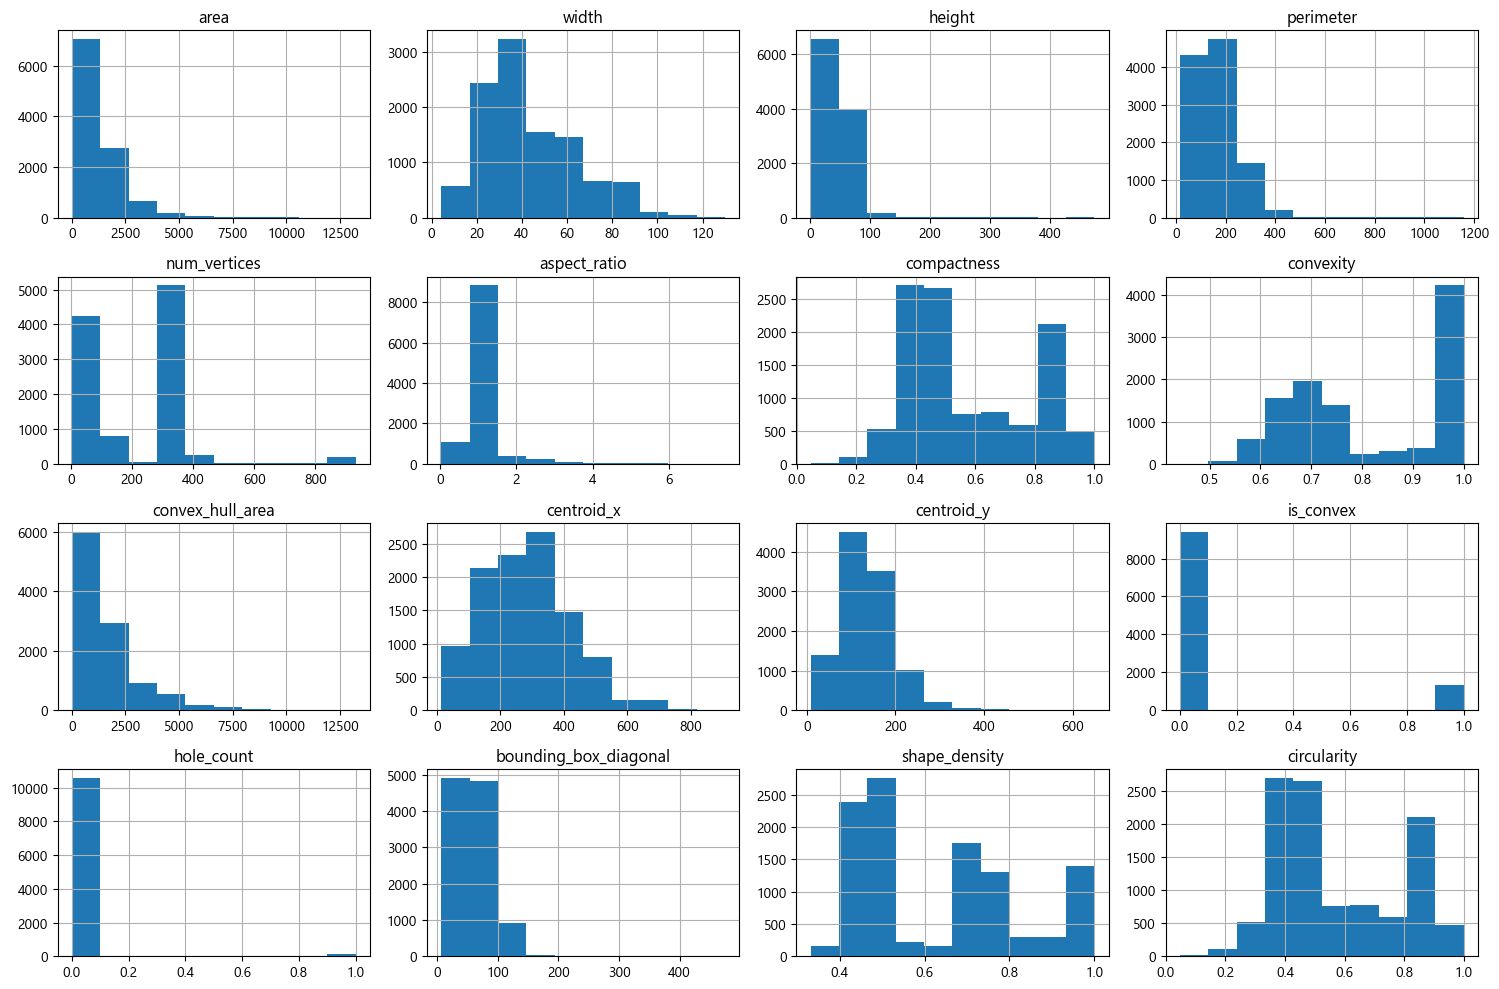

In [16]:
# prompt: df 각 컬럼의 분포 확인

import matplotlib.pyplot as plt
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 4857 entries, 4 to 10721
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gear_type                  4857 non-null   object 
 1   split                      4857 non-null   object 
 2   prompt                     4857 non-null   object 
 3   dxf_content                4857 non-null   object 
 4   dxf_doc                    4857 non-null   object 
 5   polygon                    4857 non-null   object 
 6   area                       4857 non-null   float64
 7   width                      4857 non-null   float64
 8   height                     4857 non-null   float64
 9   perimeter                  4857 non-null   float64
 10  num_vertices               4857 non-null   int64  
 11  aspect_ratio               4857 non-null   float64
 12  compactness                4857 non-null   float64
 13  convexity                  4857 non-null   float64
 

None

,gear_type,split,prompt,dxf_content,dxf_doc,polygon,area,width,height,perimeter,...,centroid_x,centroid_y,is_convex,hole_count,bounding_box_diagonal,shape_density,circularity,fourier_descriptors,polygon_vector,fourier_descriptor_vector
4,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 165.5 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((399.60666274 163.95, 418.740726399 1...",1728.780714,59.789578,59.789872,221.199080,...,383.444898,161.031023,0,0,84.555440,0.483601,0.444000,"[[1.0, 0.7096695320152538, 0.4168815375648041,...","[399.60666274, 163.95, 418.740726399, 163.95, ...","[1.0, 0.7096695320152538, 0.4168815375648041, ..."
5,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 193.7 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((490.0484041127017 192.35, 490.025827...",2083.564229,64.797160,64.798416,237.997025,...,451.913694,189.102182,0,0,91.637911,0.496234,0.462247,"[[1.0, 0.6982735117236998, 0.3982690294139795,...","[490.0484041127017, 192.35, 490.02582760515685...","[1.0, 0.6982735117236998, 0.3982690294139795, ..."
9,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 95.0 2...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((198.82944483865313 117.6406332401869...,1633.832328,44.891798,48.699804,150.463948,...,205.800000,97.166882,0,0,66.234013,0.747331,0.906885,"[[1.0, 1.0378336639913561, 0.5551590423112972,...","[198.82944483865313, 117.6406332401869, 198.83...","[1.0, 1.0378336639913561, 0.5551590423112972, ..."
11,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 151.4 ...,<ezdxf.document.Drawing object at 0x000001719D...,"POLYGON ((366.0529452429808 150.35, 383.164831...",1243.811550,49.813875,49.814447,181.505997,...,353.848074,147.935992,0,0,70.447862,0.501244,0.474441,"[[1.0, 0.6832984945974231, 0.3721633395065524,...","[366.0529452429808, 150.35, 383.1648318913417,...","[1.0, 0.6832984945974231, 0.3721633395065524, ..."
12,Spur Gears,train,"{'Allowable Torque (Nm)': None, 'Backlash Adju...",0 SECTION 2 ENTITIES 0 LINE 8 0 62 4 10 99.2 2...,<ezdxf.document.Drawing object at 0x000001719D...,POLYGON ((129.14999999999998 44.84999999999999...,1123.297721,29.900000,37.600000,133.862742,...,114.200000,63.634501,1,0,48.039255,0.999162,0.787744,"[[1.0, 1.1824194941898918, 1.967172177680278, ...","[129.14999999999998, 44.849999999999994, 99.25...","[1.0, 1.1824194941898918, 1.967172177680278, 0..."


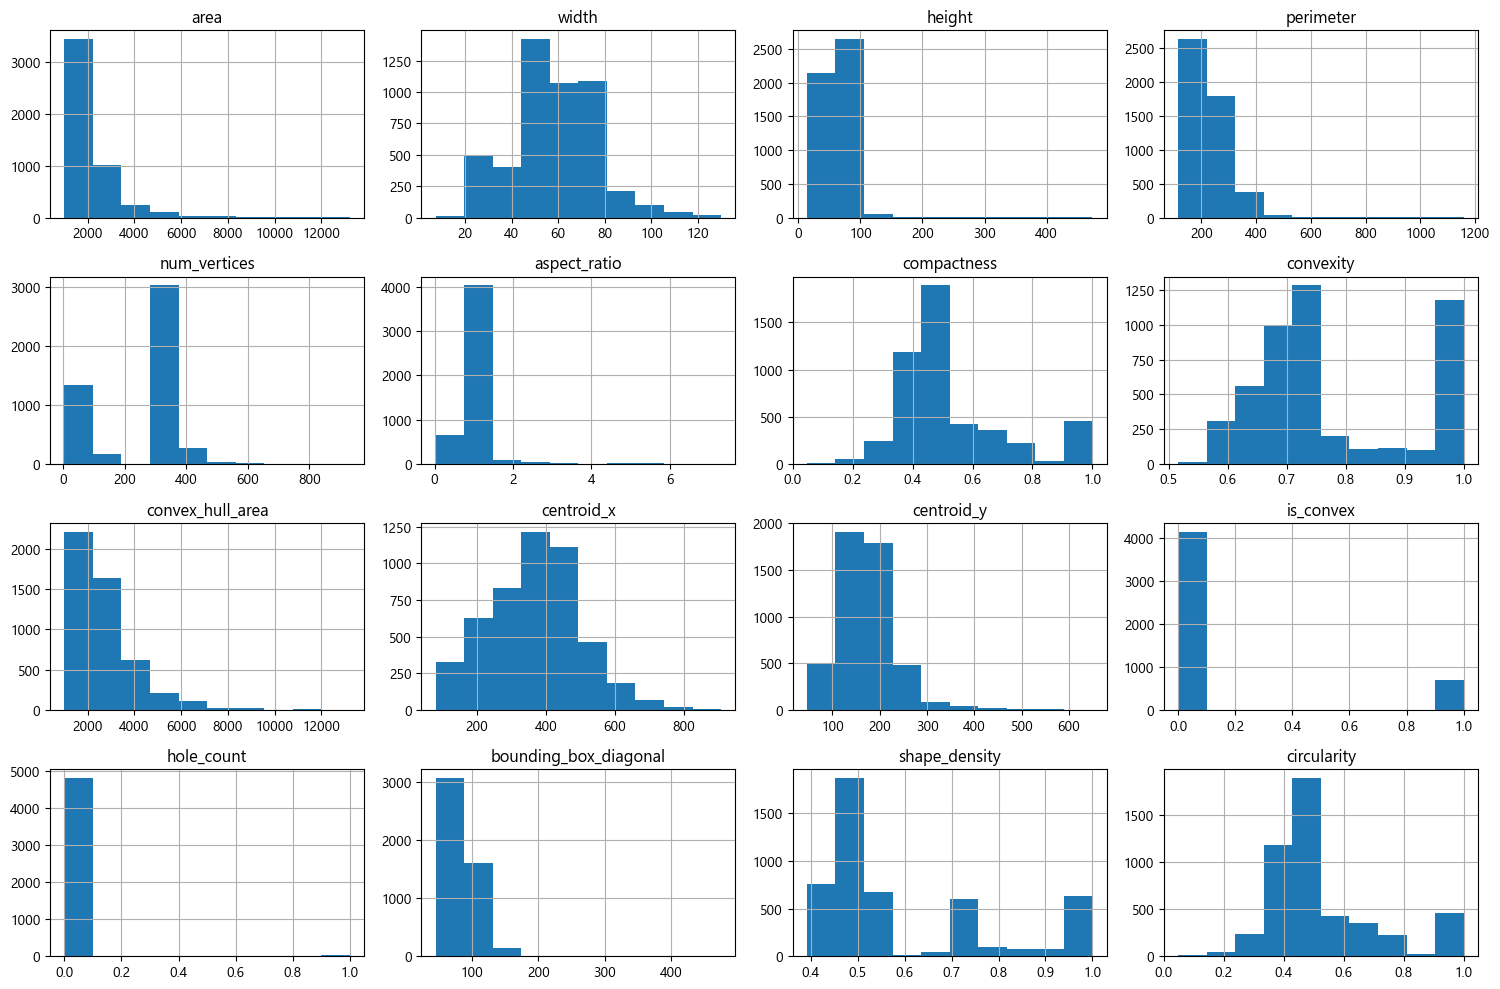

In [17]:
# prompt: 면적이 너무 작은 도형은 드롭

import matplotlib.pyplot as plt
area_threshold_absolute = 1000  # 매우 작은 면적의 절대 기준값 (예: 0.01 제곱 단위)
df = df[df['area'] >= area_threshold_absolute]

# 또는, 각 파일의 최대 면적 대비 상대적인 기준으로 드롭할 수도 있습니다.
# 예시: 각 파일 내에서 가장 큰 도형 면적의 0.1% 미만인 도형 드롭
# def drop_small_polygons_relative(row, relative_threshold=0.001):
#     if row['polygon'] is None:
#         return False # Keep None rows or handle them separately
#     if row['area'] is None:
#         return False # Keep rows with no calculated area

#     # Find max area within the same original dxf file if needed
#     # This would require grouping by the original file identifier.
#     # For simplicity here, let's assume the 'area' is already calculated per polygon.
#     # If you need max area *per original file*, you'd need a different approach,
#     # perhaps grouping by 'original_file_id' before applying this filter.

#     # For now, let's use a global threshold or a per-row absolute threshold.
#     # To implement a per-file relative threshold, you'd need the max area *of that file*.
#     # Let's stick to the absolute threshold for simplicity based on the current structure.
#     # The example code above implemented an absolute drop.

#     # If you want a relative threshold *based on the largest polygon in the whole dataset*:
#     # max_area_global = df['area'].max()
#     # if row['area'] < max_area_global * relative_threshold:
#     #     return False
#     # return True

# # Apply the relative drop function (if you choose this approach instead of absolute)
# # df = df[df.apply(drop_small_polygons_relative, axis=1)]


display(df.info())
display(df.head())

df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()


## Save Dataframe to Google Drive

In [18]:
# # prompt: df를 google drive에 저장

# # DataFrame을 CSV 파일로 저장
# df = df.drop(columns=['gear_type', 'split', 'prompt','dxf_content','dxf_doc','polygon'])

# df.to_csv('/content/drive/MyDrive/dxf_data_with_features.csv', index=False)

# print("DataFrame이 Google Drive에 저장되었습니다: /content/drive/MyDrive/dxf_data_with_features.csv")

## Load Data from Google Drive

In [19]:
# # # dataframe을 google drive 에서 불러와서 검증

# import pandas as pd
# # Google Drive에서 CSV 파일 불러오기
# try:
#     df = pd.read_csv('/content/drive/MyDrive/dxf_data_with_features.csv')
#     print("DataFrame을 Google Drive에서 성공적으로 불러왔습니다.")
#     # 불러온 DataFrame 검증 (예: 처음 5행 출력)
#     display(df.head())
#     # 불러온 DataFrame 정보 확인
#     display(df.info())
# except FileNotFoundError:
#     print("Google Drive에서 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
# except Exception as e:
#     print(f"파일을 불러오는 중 오류가 발생했습니다: {e}")



In [20]:
# # prompt: df_loaded를 각 타입에 맞게 형변환 하는 코드 작성 (numpy array 등)

# import pandas as pd
# import numpy as np
# # 'polygon_vector' 컬럼을 NumPy 배열로 변환
# # 리스트 길이를 맞춰야 NumPy 배열로 변환이 용이하므로, 패딩 또는 길이를 통일하는 과정이 필요할 수 있습니다.
# # 여기서는 각 리스트를 NumPy 배열로 저장하는 방식을 사용합니다.
# df['polygon_vector'] = df['polygon_vector'].parallel_apply(
#     lambda x: np.array(eval(x)) if pd.notna(x) else np.array([]) # 문자열 형태의 리스트를 eval()로 변환
# )

# # 'fourier_descriptor_vector' 컬럼을 NumPy 배열로 변환
# df['fourier_descriptor_vector'] = df['fourier_descriptor_vector'].parallel_apply(
#     lambda x: np.array(eval(x)) if pd.notna(x) else np.array([]) # 문자열 형태의 리스트를 eval()로 변환
# )

# # 나머지 수치형 피처 컬럼을 NumPy 배열로 변환 (각 컬럼별로)
# # 예시로 몇 가지 컬럼을 선택하여 변환합니다. 실제 사용하는 컬럼에 맞게 수정하세요.
# numeric_features = ['area', 'width', 'height', 'perimeter', 'num_vertices', 'aspect_ratio',
#                     'compactness', 'convexity', 'convex_hull_area', 'centroid_x',
#                     'centroid_y', 'is_convex', 'hole_count', 'bounding_box_diagonal',
#                     'shape_density', 'circularity']

# for col in numeric_features:
#     if col in df.columns:
#         df[f'{col}'] = df[col].to_numpy()
#     else:
#         print(f"Warning: Column '{col}' not found in DataFrame.")

# # 변환된 컬럼 확인
# display(df.head())
# display(df.info())

# # 변환된 NumPy 배열에 접근하는 예시
# # 첫 번째 행의 polygon_vector_np에 접근
# first_polygon_vector_np = df.loc[0, 'polygon_vector']
# print(f"First polygon_vector_np (type: {type(first_polygon_vector_np)}): {first_polygon_vector_np}")

# # 첫 번째 행의 fourier_descriptor_vector_np에 접근
# first_fourier_descriptor_vector_np = df.loc[0, 'fourier_descriptor_vector']
# print(f"First fourier_descriptor_vector_np (type: {type(first_fourier_descriptor_vector_np)}): {first_fourier_descriptor_vector_np}")

# # 첫 번째 행의 'area_np'에 접근
# if 'area' in df.columns:
#     first_area_np = df.loc[0, 'area']
#     print(f"First area_np (type: {type(first_area_np)}): {first_area_np}")


# Model

## Vectorize features

In [21]:
# prompt: df에서 shape features를 모델 학습용으로 사용하기 위해 numpy vector화하여 별도 변수에 저장. fourier_descriptor_vector와 polygon_vector도

import numpy as np
# Combine all feature columns into a single list of vectors for model training
# We will use the 'area', 'perimeter', 'num_vertices', 'aspect_ratio', 'compactness', 'circularity',
# 'convexity', 'hole_count', 'bounding_box_diagonal', 'shape_density' from features_df,
# the 'fourier_descriptor_vector', and the 'polygon_vector'.

# First, let's select the relevant columns from the features_df (which is now part of df)
shape_feature_cols = [
    'area', 'perimeter', 'num_vertices', 'aspect_ratio', 'compactness', 'circularity',
    'convexity', 'hole_count', 'bounding_box_diagonal', 'shape_density', 'width', 'height',
    'convex_hull_area', 'centroid_x', 'centroid_y', 'is_convex' # Added more features from extract_polygon_features
]

# Ensure all shape feature columns exist in the DataFrame
existing_shape_cols = [col for col in shape_feature_cols if col in df.columns]
print(f"Using shape features: {existing_shape_cols}")

# Extract shape features as a NumPy array
# Fill potential NaNs with a placeholder (e.g., 0 or the mean/median)
# For simplicity, let's fill with 0 for now, but consider more robust handling
shape_features_np = df[existing_shape_cols].fillna(0).values

# Extract fourier_descriptor_vector and polygon_vector
# Convert these lists of lists/vectors into NumPy arrays
# We need to pad them so they have the same length
# Find the maximum length for each type of vector
max_fd_len = df['fourier_descriptor_vector'].apply(len).max()
max_poly_len = df['polygon_vector'].apply(len).max()

# Pad the vectors and convert to NumPy arrays
fourier_descriptor_vectors_np = np.array([
    vec + [0] * (max_fd_len - len(vec)) for vec in df['fourier_descriptor_vector']
])

polygon_vectors_np = np.array([
    vec + [0] * (max_poly_len - len(vec)) for vec in df['polygon_vector']
])

# Now, you can combine these NumPy arrays for model training
# Concatenate shape features and fourier descriptors
X = np.hstack((shape_features_np, fourier_descriptor_vectors_np)) # Excluded polygon_vectors_np

# The target variable 'y' would depend on your specific task (e.g., classification label)
# For demonstration, let's assume a dummy target or use an existing column if available
# y = df['your_target_column'].values # Replace 'your_target_column' with your actual target column

print("Shape of shape_features_np:", shape_features_np.shape)
print("Shape of fourier_descriptor_vectors_np:", fourier_descriptor_vectors_np.shape)
print("Shape of polygon_vectors_np:", polygon_vectors_np.shape) # No longer printed
print("Shape of combined feature vector X:", X.shape)

# You can now use X (and y if available) for training a machine learning model
# Example: Using scikit-learn (install if not already installed: !pip install scikit-learn)
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression # Example model

# Assuming you have a target column 'gear_type' (replace with your actual target)
# if 'gear_type' in df.columns:
#     y = df['gear_type'].values
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train a simple model (e.g., Logistic Regression)
#     model = LogisticRegression()
#     model.fit(X_train, y_train)

#     # Evaluate the model
#     accuracy = model.score(X_test, y_test)
#     print(f"Model accuracy: {accuracy}")
# else:
#     print("No target column found. Features have been prepared in 'X'.")

Using shape features: ['area', 'perimeter', 'num_vertices', 'aspect_ratio', 'compactness', 'circularity', 'convexity', 'hole_count', 'bounding_box_diagonal', 'shape_density', 'width', 'height', 'convex_hull_area', 'centroid_x', 'centroid_y', 'is_convex']
Shape of shape_features_np: (4857, 16)
Shape of fourier_descriptor_vectors_np: (4857, 20)
Shape of polygon_vectors_np: (4857, 1862)
Shape of combined feature vector X: (4857, 36)


In [22]:
# Step: Apply StandardScaler and Prepare Scaled Piece Data Lists

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Import train_test_split here
import numpy as np

# Assuming X is the combined feature vector numpy array from previous steps
# Assuming polygon_vectors_np is available from previous steps
# Assuming df is available from previous steps

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the entire data (X) and transform it
# In a real train/test split scenario, scaling should be fitted only on training data
# and then applied to both train and test. For simplicity here, we scale the whole X.
if 'X' in globals():
    X_scaled = scaler.fit_transform(X)
    print(f"Original X shape: {X.shape}")
    print(f"Scaled X shape: {X_scaled.shape}")
    print("X_scaled min:", X_scaled.min())
    print("X_scaled max:", X_scaled.max())
    print("X_scaled mean:", X_scaled.mean())
    print("X_scaled std:", X_scaled.std())
else:
    print("Error: X not found. Cannot perform feature scaling.")
    X_scaled = None # Cannot proceed without X

# Proceed with data preparation only if X_scaled is available
if X_scaled is not None and 'polygon_vectors_np' in globals() and 'df' in globals():

    # Determine the max vertices from the shape of polygon_vectors_np
    # max_vertices_padded = polygon_vectors_np.shape[1] // 2 # This is the max padded size in terms of vertices * 2

    # Use train_test_split to split the indices of the available pieces
    num_available_pieces = len(df)
    all_indices = np.arange(num_available_pieces)

    # Split indices into train and test sets (e.g., 80% train, 20% test)
    # Splitting indices maintains the link back to the original df and polygon_vectors_np.
    train_indices, test_indices = train_test_split(all_indices, test_size=0.2, random_state=42) # random_state for reproducibility

    print(f"Total available pieces: {num_available_pieces}")
    print(f"Number of training pieces (indices): {len(train_indices)}")
    print(f"Number of testing pieces (indices): {len(test_indices)}")


    # Function to create piece_data list from a list of indices
    # Added max_fd_len to the function signature
    def create_piece_data_list(indices, X_data, polygon_vectors_data, df_data, max_fd_len):
        piece_data_list = []

        # Find the index of 'num_vertices' in the shape features
        try:
             num_vertices_feature_index = existing_shape_cols.index('num_vertices')
        except ValueError:
             print("Warning: 'num_vertices' not found in existing_shape_cols. Cannot update this feature.")
             num_vertices_feature_index = -1 # Indicate not found


        for idx_in_split in range(len(indices)):
            original_df_index = indices[idx_in_split] # Get the original index from the split list

            # Ensure original_df_index is valid for polygon_vectors_data and df_data
            if original_df_index < len(polygon_vectors_data) and original_df_index < len(df_data):

                # The polygon_vectors_np is a flattened vector [x1, y1, x2, y2, ...].
                # We need to reshape it back to [ [x1, y1], [x2, y2], ... ]
                polygon_coords_np = polygon_vectors_data[original_df_index].reshape(-1, 2)

                # --- Modified Mask Generation ---
                # Create a mask based on non-zero/non-padding points in the padded coordinates
                # Assuming padding is represented by (0,0) points AFTER the actual vertices.
                # A more robust way might be needed if (0,0) is a valid coordinate within the actual polygon.
                # For now, let's derive the mask based on the padded coords themselves.
                # Identify rows that are not exactly (0,0)
                non_zero_rows_mask = (np.abs(polygon_coords_np) > 1e-9).any(axis=1) # Check if any coordinate is non-zero

                # Find the index of the last non-zero row
                last_non_zero_index = np.where(non_zero_rows_mask)[0]
                if last_non_zero_index.size > 0:
                    last_non_zero_index = last_non_zero_index[-1]
                    # The mask should be True up to and including the last non-zero row
                    mask_np = np.zeros(polygon_coords_np.shape[0], dtype=bool)
                    mask_np[:last_non_zero_index + 1] = True
                else:
                    # If all rows are zero (e.g., empty piece), the mask is all False
                    mask_np = np.zeros(polygon_coords_np.shape[0], dtype=bool)

                # --- End Modified Mask Generation ---

                # Calculate the actual number of vertices from the mask
                num_actual_vertices_from_mask = np.sum(mask_np).item()

                # Get the features array for this piece
                features_np = X_data[original_df_index].copy() # Use X_data which is already scaled

                # Update the 'num_vertices' feature in the features array with the count from the mask
                if num_vertices_feature_index != -1:
                    # Find the index of 'num_vertices' within the scaled features X_data
                    # This requires knowing the order and composition of X_data (shape_features_np + fourier_descriptor_vectors_np)
                    # Assuming shape_features_np comes first in the hstack
                    shape_features_count = shape_features_np.shape[1] # Number of columns in shape_features_np
                    # The index in the combined X_data is the index within shape_features_np
                    feature_index_in_X = num_vertices_feature_index # Index is the same if it's in shape_features_np

                    # Ensure the index is within the bounds of the features_np array
                    if feature_index_in_X < features_np.shape[0]:
                         # Update the scaled feature value for num_vertices
                         # Need to unscale, update, and rescale this single feature value?
                         # Or, update the *unscaled* feature value and then scale the whole array?
                         # Let's update the unscaled value and then rely on the overall scaling if needed.
                         # A simpler approach: just replace the scaled value at the correct index.
                         # This assumes the scaler handles this replacement gracefully, or that
                         # the scaler is applied *after* this list is fully constructed and stacked.

                         # The X_data here is already scaled. Updating a single value in a scaled vector is tricky.
                         # Let's revisit the scaling step. Scaling should ideally happen *after* piece_data_list is created and features are stacked.

                         # Let's modify this function to return UNCALED features, and scale the whole list later.
                         # Revert X_data usage for features here, use original df_data for features.

                         # Use original features from df *before* scaling
                         original_features_for_piece = df_data[existing_shape_cols + ['fourier_descriptor_vector']].iloc[original_df_index].copy()

                         # Extract shape features and fourier descriptors separately for this piece
                         piece_shape_features = np.array(original_features_for_piece[existing_shape_cols].tolist())
                         piece_fourier_descriptors = np.array(original_features_for_piece['fourier_descriptor_vector']).flatten()

                         # Pad fourier descriptors if necessary to match the max_fd_len (need max_fd_len here or pass it)
                         # Assuming max_fd_len is available in this scope or passed as argument
                         # Let's pass max_fd_len to this function
                         # Need to get max_fd_len from the outer scope or pass it as argument.
                         # For now, let's assume max_fd_len is accessible or compute it here (less efficient).

                         # Recompute max_fd_len here for simplicity, or pass it as argument
                         # Getting max_fd_len from the full df again might be slow if called inside parallel_apply
                         # Let's assume max_fd_len is passed to the function signature

                         # Pad fourier descriptors
                         padded_fourier_descriptors = np.pad(piece_fourier_descriptors, (0, max_fd_len - len(piece_fourier_descriptors)), 'constant')

                         # Combine the unscaled features
                         combined_unscaled_features = np.hstack((piece_shape_features, padded_fourier_descriptors))


                         # Update the 'num_vertices' feature in the UNCALED combined features
                         # Find the index of 'num_vertices' in the combined_unscaled_features
                         # It's at the same index within the shape features part
                         feature_index_in_combined = num_vertices_feature_index

                         if feature_index_in_combined != -1 and feature_index_in_combined < combined_unscaled_features.shape[0]:
                              combined_unscaled_features[feature_index_in_combined] = num_actual_vertices_from_mask


                         # Store the UNCALED combined features
                         piece_data_list.append({
                             # Store polygon vertices as a NumPy array
                             'polygon_coords': polygon_coords_np.astype(np.float32),
                             'polygon_mask': mask_np, # Store the mask
                             # Store the UNCALED, updated combined features
                             'features': combined_unscaled_features.astype(np.float32)
                         })
                    else:
                         # If num_vertices feature index is out of bounds, just store features without update
                         piece_data_list.append({
                             'polygon_coords': polygon_coords_np.astype(np.float32),
                             'polygon_mask': mask_np,
                             'features': combined_unscaled_features.astype(np.float32) # Use combined_unscaled_features even if not updated
                         })

                else:
                    # If num_vertices feature was not found, just store features without update
                     # Use original features from df *before* scaling
                     original_features_for_piece = df_data[existing_shape_cols + ['fourier_descriptor_vector']].iloc[original_df_index].copy()

                     # Extract shape features and fourier descriptors separately for this piece
                     piece_shape_features = np.array(original_features_for_piece[existing_shape_cols].tolist())
                     piece_fourier_descriptors = np.array(original_features_for_piece['fourier_descriptor_vector']).flatten()

                     # Pad fourier descriptors if necessary to match the max_fd_len (need max_fd_len here or pass it)
                     # Assuming max_fd_len is available in this scope or passed as argument
                     # Let's pass max_fd_len to this function

                     # Pad fourier descriptors
                     padded_fourier_descriptors = np.pad(piece_fourier_descriptors, (0, max_fd_len - len(piece_fourier_descriptors)), 'constant')

                     # Combine the unscaled features
                     combined_unscaled_features = np.hstack((piece_shape_features, padded_fourier_descriptors))

                     piece_data_list.append({
                         'polygon_coords': polygon_coords_np.astype(np.float32),
                         'polygon_mask': mask_np,
                         'features': combined_unscaled_features.astype(np.float32) # Store unscaled features
                     })


            else:
                print(f"Warning: Original index {original_df_index} out of bounds for polygon_vectors_data or df_data. Skipping.")
                continue # Skip this index if out of bounds

        return piece_data_list

    # Recompute max_fd_len in the outer scope to pass it
    max_fd_len = df['fourier_descriptor_vector'].apply(len).max()


    # Create piece_data lists for training and testing using the original features (will be scaled later)
    # Pass max_fd_len to the function
    piece_data_train_unscaled = create_piece_data_list(train_indices, X, polygon_vectors_np, df, max_fd_len) # Pass X (unscaled features before this cell) and df
    piece_data_test_unscaled = create_piece_data_list(test_indices, X, polygon_vectors_np, df, max_fd_len) # Pass X and df

    # Now, stack the features from the unscaled piece_data lists to scale them all together
    # This ensures consistent scaling across all features.
    train_features_unscaled = np.vstack([p['features'] for p in piece_data_train_unscaled])
    test_features_unscaled = np.vstack([p['features'] for p in piece_data_test_unscaled])

    # Fit the scaler only on the training features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features_unscaled)

    # Transform both training and testing features using the scaler fitted on training data
    test_features_scaled = scaler.transform(test_features_unscaled)

    # Update the 'features' in the piece_data lists with the scaled features
    for i, piece_data in enumerate(piece_data_train_unscaled):
        piece_data['features'] = train_features_scaled[i].astype(np.float32)

    for i, piece_data in enumerate(piece_data_test_unscaled):
        piece_data['features'] = test_features_scaled[i].astype(np.float32)

    # Rename the variables to reflect they now contain scaled features
    piece_data_train_scaled = piece_data_train_unscaled
    piece_data_test_scaled = piece_data_test_unscaled


    print(f"Prepared scaled training data for {len(piece_data_train_scaled)} pieces.")
    print(f"Prepared scaled testing data for {len(piece_data_test_scaled)} pieces.")

    # Note: When initializing the environment for training, use piece_data_train_scaled:
    # env = NestingEnv(pieces_data=piece_data_train_scaled, ...)
    # For evaluation, you might use piece_data_test_scaled.

else:
    print("Required data (X, polygon_vectors_np, or df) not found. Cannot prepare scaled piece data lists.")

Original X shape: (4857, 36)
Scaled X shape: (4857, 36)
X_scaled min: -2.778538171367561
X_scaled max: 28.206208850399523
X_scaled mean: -2.217144308504968e-16
X_scaled std: 0.9860132971832719
Total available pieces: 4857
Number of training pieces (indices): 3885
Number of testing pieces (indices): 972
Prepared scaled training data for 3885 pieces.
Prepared scaled testing data for 972 pieces.


## Heuristic helper functions
Label이 없는 domain인 만큼 기존의 휴리스틱 알고리즘을 적용하여 Policy가 초반에 방향을 잡는데 도움을 준다.

Pyclipper와 Shapley 두 라이브러리 모두 CPU (C++ 라이브러리 기반)로 학습에 너무 많은 시간이 소요되었다.

위 문제로 인해 학습을 제대로 마친적이 없어 직접 구현하는 방향으로 진행한다.

In [23]:
from utils.geometry_utils import *

## DNN (Policy Network)

In [24]:
from policy import NestingDNN

## Environment

- 기본 성공/실패 보상 및 면적 비례 보상 적용
  - `NestingEnv`의 `_calculate_reward` 함수를 수정하여 조각 배치 성공 시 해당 조각의 면적에 비례하는 보상을 추가하고, 실패 시에는 기존의 음수 보상을 유지

- 조각 간 근접성 보상 계산 로직 추가
  - 배치된 조각들과 현재 조각 간의 최소 거리를 계산하는 로직을 추가합니다. 이를 위해 기존의 TorchScript 헬퍼 함수를 활용하거나 새로운 헬퍼 함수가 필요한지 검토합니다.

- 시트 경계 근접성 보상 계산 로직 추가
  - 현재 조각의 경계와 시트 경계 간의 최소 거리를 계산하는 로직을 추가합니다.



In [25]:
from environment import NestingEnv

# Train

## 환경 및 모델 초기화
준비된 Piece 데이터와 TorchScript 헬퍼 함수를 사용하여 `NestingEnv` 환경을 초기화하고, 정의된 `NestingDNN` 정책 네트워크 모델을 초기화

모델은 GPU로 이동


In [26]:
import numpy as np

# 1. Initialize the NestingEnv environment
# Use the prepared piece_data_revised
# Adjusted reward scaling parameters
# Pass the heuristic type as a string
env = NestingEnv(pieces_data=piece_data_train_scaled, 
                 heuristic_type=None,
                 # heuristic_type='bl', # Pass 'bl' or 'nfp' as string and step size
                 heuristic_step_size=5.0, 
                 area_reward_scale=0.00001,
                 distance_reward_scale=0.5,
                 distance_threshold=5.0,
                 distance_epsilon=1e-6,
                 boundary_reward_scale=2,
                 max_steps=50)  # 최대 스텝 수 설정 (필요에 따라 조정)

# 2. Initialize the NestingDNN policy network
# Determine the input dimension from the environment's observation space
# Check if the environment was initialized successfully before accessing observation_space
if env is not None and hasattr(env, 'observation_space'):
    input_dim = env.observation_space.shape[0] # Use the updated observation space size
else:
    # Handle the case where environment initialization failed
    print("Error: Environment not initialized successfully. Cannot determine input dimension.")
    input_dim = None # Set input_dim to None to prevent model initialization

# Only initialize policy_net if input_dim is valid
if input_dim is not None and input_dim > 0: # Added check for > 0
    policy_net = NestingDNN(input_dim)

    # 3. Move the model to the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net.to(device)

    print(f"Environment initialized with {len(piece_data_train_scaled)} training pieces (using scaled data) and heuristic observation.")
    print(f"Policy network initialized with input dimension: {input_dim}")
    print(f"Policy network moved to device: {device}")
    print("Reward scaling parameters have been adjusted.")
else:
    print("Policy network not initialized due to invalid input dimension or environment initialization failure.")

Environment initialized with 3885 training pieces (using scaled data) and heuristic observation.
Policy network initialized with input dimension: 39
Policy network moved to device: cuda
Reward scaling parameters have been adjusted.


## 옵티마이저 및 하이퍼파라미터 설정
모델의 가중치를 업데이트할 옵티마이저(예: Adam)를 설정하고, 학습률, 할인 계수(gamma), 에피소드 수 등 학습에 필요한 하이퍼파라미터 정의


**Reasoning**:
Set up the Adam optimizer and define hyperparameters for the training process.



In [27]:
import torch.optim as optim
from collections import deque # Import deque

# 1. Instantiate the Adam optimizer
# Reduce the learning rate to potentially improve stability
optimizer = optim.Adam(policy_net.parameters(), lr=0.0005) # Reduced learning rate from 0.001 to 0.0005

# 2. Define the discount factor (gamma)
gamma = 0.99

# 3. Define the total number of training episodes
total_episodes = 1000

# 4. Define other hyperparameters (example values, adjust as needed)
batch_size = 4 # Batch size for training updates (if applicable)
clip_ratio = 0.2 # Clipping parameter for PPO (if using PPO-like updates)
entropy_coef = 0.5 # Entropy coefficient for exploration (Increased from 0.01)
value_loss_coef = 0.5 # Value function loss coefficient

# Initialize tracking variables if they don't exist (for resuming training)
# Check if these variables already exist in the global scope and retain their values if they do
# This allows resuming from an interrupted run if the kernel state is preserved.

episode_rewards = []
recent_episode_rewards = deque(maxlen=100)
start_episode = 0 # Start from episode 0 if not resuming


print("Optimizer and hyperparameters defined.")
print(f"Optimizer: {optimizer}")
print(f"Gamma: {gamma}")
print(f"Total Episodes: {total_episodes}")
print(f"Batch Size: {batch_size}")
print(f"Clip Ratio: {clip_ratio}")
print(f"Entropy Coefficient: {entropy_coef}")
print(f"Value Loss Coefficient: {value_loss_coef}")
print(f"Initial start_episode: {start_episode}") # Print initial start_episode

Optimizer and hyperparameters defined.
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
Gamma: 0.99
Total Episodes: 1000
Batch Size: 4
Clip Ratio: 0.2
Entropy Coefficient: 0.5
Value Loss Coefficient: 0.5
Initial start_episode: 0


## 학습 루프 구현

[2025-06-18 18:05:35] Starting/Resuming training...
Previous environment renderer closed.
Checkpoint loaded successfully. Resuming training from episode 541.
Initial start_episode: 541
colision or out of bounds detected, new heuristic location (0.0, 0.0)
colision or out of bounds detected, new heuristic location (70.0, 0.0)
colision or out of bounds detected, new heuristic location (155.0, 0.0)
colision or out of bounds detected, new heuristic location (185.0, 0.0)
colision or out of bounds detected, new heuristic location (210.0, 0.0)
colision or out of bounds detected, new heuristic location (250.0, 0.0)
colision or out of bounds detected, new heuristic location (280.0, 0.0)
colision or out of bounds detected, new heuristic location (285.0, 0.0)
colision or out of bounds detected, new heuristic location (345.0, 0.0)
colision or out of bounds detected, new heuristic location (65.0, 0.0)
colision or out of bounds detected, new heuristic location (225.0, 40.0)
colision or out of bounds 

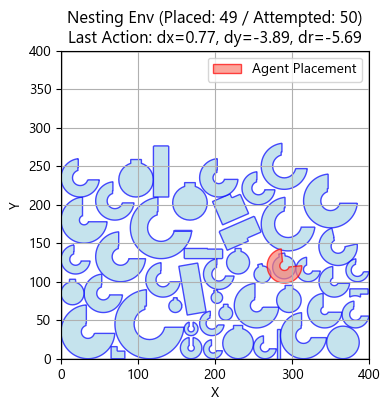

[2025-06-18 18:15:38] Episode 542/1000 (54.20%), Total Reward: -31.57, Avg Recent Reward: -1452.67, Steps: 50
Updated model with 1 full-trajectory batch (no minibatch)
Model checkpoint saved to ./models\checkpoint_episode_542.pth
colision or out of bounds detected, new heuristic location (0.0, 0.0)
colision or out of bounds detected, new heuristic location (70.0, 0.0)
colision or out of bounds detected, new heuristic location (155.0, 0.0)
colision or out of bounds detected, new heuristic location (185.0, 0.0)
colision or out of bounds detected, new heuristic location (210.0, 0.0)
colision or out of bounds detected, new heuristic location (250.0, 0.0)
colision or out of bounds detected, new heuristic location (280.0, 0.0)
colision or out of bounds detected, new heuristic location (285.0, 0.0)
colision or out of bounds detected, new heuristic location (345.0, 0.0)
colision or out of bounds detected, new heuristic location (65.0, 0.0)
colision or out of bounds detected, new heuristic loca

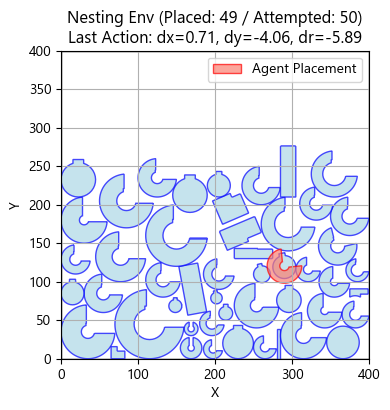

[2025-06-18 18:25:57] Episode 543/1000 (54.30%), Total Reward: -31.59, Avg Recent Reward: -1418.81, Steps: 50
Updated model with 1 full-trajectory batch (no minibatch)
colision or out of bounds detected, new heuristic location (0.0, 0.0)
colision or out of bounds detected, new heuristic location (70.0, 0.0)
colision or out of bounds detected, new heuristic location (155.0, 0.0)
colision or out of bounds detected, new heuristic location (185.0, 0.0)
colision or out of bounds detected, new heuristic location (210.0, 0.0)
colision or out of bounds detected, new heuristic location (250.0, 0.0)
colision or out of bounds detected, new heuristic location (280.0, 0.0)
colision or out of bounds detected, new heuristic location (285.0, 0.0)
colision or out of bounds detected, new heuristic location (345.0, 0.0)
colision or out of bounds detected, new heuristic location (65.0, 0.0)
colision or out of bounds detected, new heuristic location (225.0, 40.0)
colision or out of bounds detected, new heu

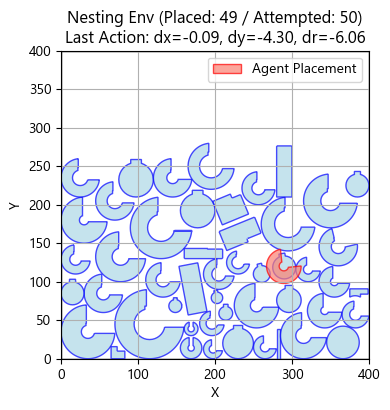

[2025-06-18 18:36:25] Episode 544/1000 (54.40%), Total Reward: -31.59, Avg Recent Reward: -1384.99, Steps: 50
Updated model with 1 full-trajectory batch (no minibatch)
Model checkpoint saved to ./models\checkpoint_episode_544.pth
colision or out of bounds detected, new heuristic location (0.0, 0.0)
colision or out of bounds detected, new heuristic location (70.0, 0.0)
colision or out of bounds detected, new heuristic location (155.0, 0.0)
colision or out of bounds detected, new heuristic location (185.0, 0.0)
colision or out of bounds detected, new heuristic location (210.0, 0.0)
colision or out of bounds detected, new heuristic location (250.0, 0.0)
colision or out of bounds detected, new heuristic location (280.0, 0.0)
colision or out of bounds detected, new heuristic location (285.0, 0.0)
colision or out of bounds detected, new heuristic location (345.0, 0.0)
colision or out of bounds detected, new heuristic location (65.0, 0.0)
colision or out of bounds detected, new heuristic loca

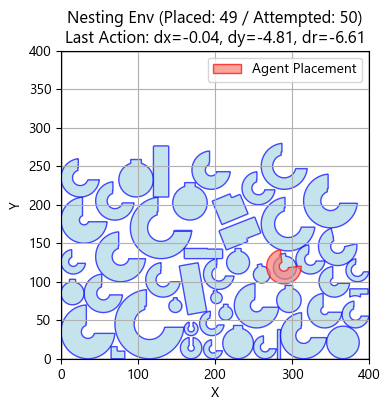

[2025-06-18 18:46:47] Episode 545/1000 (54.50%), Total Reward: -31.70, Avg Recent Reward: -1351.16, Steps: 50
Updated model with 1 full-trajectory batch (no minibatch)
colision or out of bounds detected, new heuristic location (0.0, 0.0)
colision or out of bounds detected, new heuristic location (70.0, 0.0)
colision or out of bounds detected, new heuristic location (155.0, 0.0)
colision or out of bounds detected, new heuristic location (185.0, 0.0)
colision or out of bounds detected, new heuristic location (210.0, 0.0)
colision or out of bounds detected, new heuristic location (250.0, 0.0)
colision or out of bounds detected, new heuristic location (280.0, 0.0)
colision or out of bounds detected, new heuristic location (285.0, 0.0)
colision or out of bounds detected, new heuristic location (345.0, 0.0)
colision or out of bounds detected, new heuristic location (65.0, 0.0)
colision or out of bounds detected, new heuristic location (225.0, 40.0)
colision or out of bounds detected, new heu

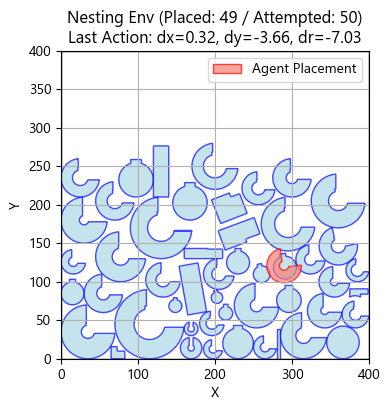

[2025-06-18 18:57:16] Episode 546/1000 (54.60%), Total Reward: -31.70, Avg Recent Reward: -1317.30, Steps: 50
Updated model with 1 full-trajectory batch (no minibatch)
Model checkpoint saved to ./models\checkpoint_episode_546.pth
colision or out of bounds detected, new heuristic location (0.0, 0.0)
colision or out of bounds detected, new heuristic location (70.0, 0.0)
colision or out of bounds detected, new heuristic location (155.0, 0.0)
colision or out of bounds detected, new heuristic location (185.0, 0.0)
colision or out of bounds detected, new heuristic location (210.0, 0.0)
colision or out of bounds detected, new heuristic location (250.0, 0.0)
colision or out of bounds detected, new heuristic location (280.0, 0.0)
colision or out of bounds detected, new heuristic location (285.0, 0.0)
colision or out of bounds detected, new heuristic location (345.0, 0.0)
colision or out of bounds detected, new heuristic location (65.0, 0.0)
colision or out of bounds detected, new heuristic loca

In [ ]:
from collections import deque
import torch.optim as optim
import os
import torch
import torch.nn.functional as F # Import functional for losses
import torch.nn.utils as torch_utils # Import torch.nn.utils for clipping
import time

model_save_dir = "./models"
# 모델 저장 디렉토리 생성
os.makedirs(model_save_dir, exist_ok=True)

# 체크포인트 파일 경로 정의
checkpoint_path = os.path.join(model_save_dir, "checkpoint_episode.pth")
time_str = time.strftime("%Y-%m-%d %H:%M:%S") # Get current time

render_step = 50

# Initialize variables for tracking training progress
# Check if these variables already exist in the global scope and retain their values if they do
# This allows resuming from an interrupted run if the kernel state is preserved.
if 'episode_rewards' not in globals():
    episode_rewards = []
if 'recent_episode_rewards' not in globals():
    recent_episode_rewards = deque(maxlen=100)
if 'optimizer' not in globals():
    # Assume optimizer and policy_net are defined in previous cells
    print("Optimizer not found. Please ensure the optimizer and policy_net cells have been run.")
    # You might need to define or load policy_net and optimizer here if running this cell standalone
    # For resuming, assume they exist from previous successful runs.
    pass
if 'total_episodes' not in globals():
     # Assume total_episodes is defined in a previous cell
     print("total_episodes not found. Please ensure hyperparameters cell has been run.")
     total_episodes = 1000 # Fallback value
if 'gamma' not in globals():
    gamma = 0.99 # Fallback value
if 'clip_ratio' not in globals():
    clip_ratio = 0.2 # Fallback value
if 'entropy_coef' not in globals():
    entropy_coef = 0.01 # Fallback value
if 'value_loss_coef' not in globals():
    value_loss_coef = 0.5 # Fallback value
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Fallback value
    print(f"Device not found, defaulting to {device}. Please ensure environment/model init cell has been run.")

# Assume policy_net, env, optimizer, total_episodes, gamma, device are defined from previous cells
# Assuming policy_net is now the updated NestingDNN with actor and critic heads and get_action_and_value/evaluate_action methods

print(f"[{time_str}] Starting/Resuming training...")

# Ensure the environment is properly closed from previous runs if any
# env.close() # Keep this outside the loop if you want to close only once at the very end
# If you want to ensure it's closed before starting a new training session in the same notebook run:
try:
    env.close()
    print("Previous environment renderer closed.")
except Exception as e:
    print(f"Could not close previous environment renderer: {e}")


if os.path.exists(checkpoint_path):
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        policy_net.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_episode = checkpoint['episode'] + 1 # Start from the next episode
        episode_rewards = checkpoint.get('episode_rewards', []) # Load episode rewards if saved
        recent_episode_rewards = deque(episode_rewards[-100:], maxlen=100) # Re-initialize deque with recent rewards
        print(f"Checkpoint loaded successfully. Resuming training from episode {start_episode}.")
    except Exception as e:
        print(f"Error loading checkpoint: {e}. Starting training from episode 0.")
        # Optionally, reset model and optimizer to a clean state if loading fails
        # policy_net.apply(lambda m: None) # Reset model parameters - need proper re-initialization if desired
        # optimizer = optim.Adam(policy_net.parameters(), lr=optimizer.param_groups[0]['lr']) # Re-initialize optimizer


print(f"Initial start_episode: {start_episode}")


for episode in range(start_episode, total_episodes):
    # Reset the environment for the start of a new episode
    observation_np, info = env.reset()
    done = False
    episode_reward = 0
    # Collect data for PPO update
    batch_observations = []
    batch_actions = []
    batch_rewards = []
    batch_log_probs = []
    batch_values = []
    step_count = 0 # Track steps within an episode

    # Convert initial observation to tensor and move to device
    observation = torch.tensor(observation_np, dtype=torch.float32).unsqueeze(0).to(device) # Add batch dimension

    # 스텝 배치 처리를 위한 변수 설정
    step_batch_size = 4  # 한 번에 처리할 스텝 수
    step_batch_observations = []
    step_batch_done = []

    # 에피소드 내 배치 처리 루프
    while not done:
        # 배치 처리를 위한 데이터 수집
        step_batch_observations.clear()
        step_batch_done.clear()

        # 현재 관찰값을 첫 번째 배치 요소로 추가
        step_batch_observations.append(observation)
        step_batch_done.append(done)

        # 배치 처리를 위해 가상의 미래 상태 예측 (1~step_batch_size-1)
        for batch_step in range(1, step_batch_size):
            # 이미 끝난 에피소드인 경우 더 이상 배치에 추가하지 않음
            if step_batch_done[-1]:
                break

            # 임시 관찰값을 복제하여 배치에 추가
            # 실제 실행 전이므로 현재 상태의 복사본을 사용
            step_batch_observations.append(step_batch_observations[-1].clone())
            step_batch_done.append(False)

        # 실제 배치 크기 계산 (도중에 에피소드가 끝날 수 있음)
        actual_batch_size = len(step_batch_observations)

        # 배치 관찰값 스택
        batched_observations = torch.cat(step_batch_observations, dim=0)

        # 정책 네트워크에서 배치로 액션 얻기
        with torch.no_grad():
            batched_actions, batched_log_probs, batched_entropies, batched_values = policy_net.get_action_and_value(batched_observations)

        # 배치의 각 스텝을 순차적으로 실행
        for batch_idx in range(actual_batch_size):
            if step_batch_done[batch_idx]:
                continue

            # 배치에서 현재 스텝의 액션 추출
            action_tensor = batched_actions[batch_idx:batch_idx+1]  # 배치 차원 유지
            log_prob_tensor = batched_log_probs[batch_idx:batch_idx+1]  # 배치 차원 유지
            value_tensor = batched_values[batch_idx:batch_idx+1]  # 배치 차원 유지

            # 액션을 환경에 적용
            action_np = action_tensor.squeeze(0).cpu().numpy()
            next_observation_np, reward, terminated, truncated, info = env.step(action_np)

            # 결과 저장
            batch_observations.append(observation.squeeze(0))
            batch_actions.append(action_tensor.squeeze(0))
            batch_rewards.append(reward)
            batch_log_probs.append(log_prob_tensor.squeeze(0))
            batch_values.append(value_tensor.squeeze(0))

            # 상태 업데이트
            observation = torch.tensor(next_observation_np, dtype=torch.float32).unsqueeze(0).to(device)
            done = terminated or truncated
            episode_reward += reward
            step_count += 1

            # 렌더링 (필요한 경우)
            if step_count % render_step == 0:
                env.render()
                env.close()

            # 에피소드가 끝나면 배치 처리 중단
            if done:
                break

        # 에피소드가 끝나면 루프 종료
        if done:
            break

    # Store episode reward and recent rewards
    episode_rewards.append(episode_reward)
    recent_episode_rewards.append(episode_reward)

    # Calculate average reward over recent episodes for logging
    avg_recent_reward = sum(recent_episode_rewards) / len(recent_episode_rewards) if recent_episode_rewards else 0

    # Print training progress including percentage
    # Calculate percentage progress
    progress_percent = (episode + 1) / total_episodes * 100
    time_str = time.strftime("%Y-%m-%d %H:%M:%S") # Get current time
    print(f"[{time_str}] Episode {episode + 1}/{total_episodes} ({progress_percent:.2f}%), Total Reward: {episode_reward:.2f}, Avg Recent Reward: {avg_recent_reward:.2f}, Steps: {step_count}")

    # --- Model Update Logic (PPO) with Batch Processing ---
    # Check for empty batch observations before stacking
    if len(batch_observations) == 0:
        print(f"Skipping model update for episode {episode + 1} due to empty batch observations.")
        continue # Skip update if no observations were collected

    # Convert collected data to tensors
    batch_observations = torch.stack(batch_observations).to(device)
    batch_actions = torch.stack(batch_actions).to(device)
    batch_rewards = torch.tensor(batch_rewards, dtype=torch.float32).to(device)
    batch_log_probs = torch.stack(batch_log_probs).to(device)
    batch_values = torch.stack(batch_values).to(device)

    # Calculate returns (discounted future rewards)
    returns = []
    R = 0
    for r in reversed(batch_rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32).to(device)

    # Calculate advantages (returns - value estimates)
    advantages = returns - batch_values

    # Normalize advantages (optional but common)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # === 미니배치 제거: trajectory 전체로 1회만 업데이트 ===

    # Get new action probabilities, entropy, and values from the current policy for the whole trajectory
    new_log_probs, entropy, new_values = policy_net.evaluate_action(batch_observations, batch_actions)

    # 차원 맞추기
    if new_log_probs.dim() > 1:
        new_log_probs = new_log_probs.sum(dim=-1)
    if batch_log_probs.dim() > 1:
        batch_log_probs = batch_log_probs.sum(dim=-1)

    # Calculate the ratio of new to old probabilities
    ratio = torch.exp(new_log_probs - batch_log_probs)

    # advantages 차원 맞추기
    if ratio.shape != advantages.shape:
        if len(ratio.shape) < len(advantages.shape):
            ratio = ratio.unsqueeze(-1).expand_as(advantages)
        else:
            advantages = advantages.mean(dim=1)

    # Calculate the clipped surrogate objective
    surrogate1 = ratio * advantages
    surrogate2 = torch.clamp(ratio, 1 - clip_ratio, 1 + clip_ratio) * advantages
    policy_loss = -torch.min(surrogate1, surrogate2).mean()

    # Calculate the value loss
    value_loss = F.mse_loss(new_values, returns.unsqueeze(1))

    # Add entropy bonus for exploration
    total_loss = policy_loss + value_loss_coef * value_loss - entropy_coef * entropy.mean()

    # Perform optimizer step
    optimizer.zero_grad()
    total_loss.backward()

    # --- Check Gradients for NaN/Inf ---
    nan_in_gradients = False
    for name, param in policy_net.named_parameters():
        if param.grad is not None:
            if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                print(f"Warning: NaN or Inf found in gradient of parameter: {name}")
                nan_in_gradients = True
                break

    if nan_in_gradients:
        print(f"Skipping optimizer step for episode {episode + 1} due to NaN/Inf in gradients.")
        continue

    # Apply Gradient Clipping
    torch_utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)

    optimizer.step()

    print(f"Updated model with 1 full-trajectory batch (no minibatch)")

    # Save checkpoint periodically
    if (episode + 1) % 2 == 0: # Save every 2 episodes
        checkpoint_path_episode = os.path.join(model_save_dir, f"checkpoint_episode_{episode + 1}.pth")
        torch.save({
            'episode': episode,
            'model_state_dict': policy_net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'episode_rewards': list(episode_rewards), # Save as list for easy loading
            'recent_episode_rewards': list(recent_episode_rewards) # Save as list
        }, checkpoint_path_episode)
        print(f"Model checkpoint saved to {checkpoint_path_episode}")

    # Save the latest checkpoint after every episode
    # This simplifies resuming as you only need to load the single 'checkpoint.pth' file
    torch.save({
        'episode': episode,
        'model_state_dict': policy_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_rewards': list(episode_rewards), # Save as list
        'recent_episode_rewards': list(recent_episode_rewards) # Save as list
    }, checkpoint_path)
    # print(f"Latest checkpoint saved to {checkpoint_path}") # Optional: print every episode save


print("Training finished.")

# Save the final trained model (optional, the last checkpoint might be sufficient)
# model_save_dir = "/content/drive/MyDrive/nesting_rl_models" # Define your save directory
# os.makedirs(model_save_dir, exist_ok=True) # Create directory if it doesn't exist
# model_path = os.path.join(model_save_dir, "policy_net_final.pth")
# torch.save(policy_net.state_dict(), model_path)
# print(f"Final trained model saved to {model_path}")

# Close the environment rendering window at the very end
env.close()